# Protocol for analysis of labeled proteomics data

## Introduction

This jupyter notebook contains a complete workflow to process and quantify TMT and iTRAQ labelled MS/MS data.

Database searches are performed using [searchGUI](https://github.com/compomics/searchgui) and the subsequent search results are filtered using [PeptideShaker](https://github.com/compomics/peptide-shaker).

This pipeline currently only supports experimental setups where **each channel represents one sample**. It is currently not possible to merge results from different 

## Usage

1. Convert raw MS data to MGF files (PeptideShaker currently requires all input files to be in the MGF format). We recommend [ProteoWizard](http://proteowizard.sourceforge.net/).

2. Use the "Home" screen of the Jupyter environment (normally at http://0.0.0.0:8888/tree?), navigate to the `IN` directory and copy all MGF files there (using the `Upload` button)

3. Scroll down in this document until you reach the `Workflow` section to start processing your data.


## Maintainer

  * Veit Schwammle (veits@bmb.sdu.dk)
  * Johannes Griss (johannes.griss@meduniwien.ac.at)
  * Goran Vinterhalter

## Software

Specify links for documentation and tutorials of used software, source code, publications and use cases. Detail versions of each used software. Alternatively, provide links to the software descriptions in https://bio.tools where this information is available.

## Diagram

Provide a simple diagram of functionality of the workflow/software. We recommend using controlled vocabularies for input/output data types and file formats as well as provided operation of the tool(s). You can use http://edamontology.org terms for the description.

__TODO: example__

## System requirements

Fill in the following items:
Required hard disk space for docker image, input and output files: 
You will need space for your raw files and files from the down-stream analysis (mostly < 1 GB)

Required memory: Recommend min. 4 GB or RAM

Recommmended number of threads: 4-8

## Example 

Presentation of well-documented instructions and commands to run the example use case. Depending on the use case and the software, provide link(s) to open the web service incorportated in the Docker image (e.g. 0.0.0.0:8080), bash commands to run programs from the command line and additional code for e.g. checking and visualizing the (intermediate) results. 

The example data file is an extract of spectra from the iTRAQ 8-plex data in ref. https://doi.org/10.1371/journal.pone.0137048


Instead of providing the instructions in this notebook, one can also provide a link to a notebook containing the example use case.

## More general use case (optional)
Provide link to notebook with a generalized use case that easily can be adapted to e.g. process different input data and concurrent parametrization.




# Workflow


In [99]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Specify parameters for database search and evaluation of identified peptide-spectrum matches:

In [105]:
# This cell contains the complete code to
# 1.) Display the GUI for the user to enter the search parameters
# 2.) Launch the search based on these parameters
# 3.) Display a button once the search is complete to execute the subsequent R analysis code

search_in = None

def complete_function():
    global search_in
    
    search_in = search_ui_out
    search_in["on_search_complete"] = search_complete
    %run "Scripts/search.ipy"
    
def search_complete():
    global btn_next_cell_in
    
    # Display a button to execute the next R cell(s)
    btn_next_cell_in = {"description": "Run R analysis", "n_cells_to_run": 9}
    %run "Scripts/btn_next_cell.ipy"

search_ui_in = {"on_complete_description": "Run my search", "on_complete_function": complete_function}

%run "Scripts/search_ui.ipy"

Deleting existing files in /home/biodocker/OUT
Adapting MGF titles...
['/home/biodocker/IN/iTRAQCancer.mgf']
Extracting reporter peaks...
Creating decoy database...
Start: Creating search parameter file
    Completed in 1 sec
Start: SearchCLI
    Completed in 57 sec
Start: PeptideShakerCLI processing
    Completed in 33 sec
Start: ReportCLI (conversion to .tsv)
    Completed in 5 sec
Search Done.


Button(description='Run R analysis', layout=Layout(width='30%'), style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convert Search Settings into R Objects

These cells should not produce any output.

In [121]:
# Since py2ri cannot convert dict objects, simply save everything R needs as a JSON string

# remove the callback function first
search_in.pop("on_search_complete", None)

import json
search_in_string = json.dumps(search_in)
search_out_string = json.dumps(search_out)

In [122]:
%%R -i search_in_string,search_out_string
# Convert the JSON objects back into "natural" R objects
suppressWarnings(library(rjson))

search_in = fromJSON(search_in_string, simplify = T)
search_out = fromJSON(search_out_string, simplify = T)


# load the experimental design
ExpDesign <- read.table(search_in["exp_design_file"][[1]],sep="\t",header=T)

rm(search_in_string, search_out_string)

### Load and Quantify Spectra at the peptide level

[1] "Processing identification data..."
/home/biodocker/IN 
                "" 
[1] "Processing files from folder /home/biodocker/IN"
[1] "Loaded 937 PSMs"
[1] "Filtered 740 PSMs @ 0.01 FDR"
Scanning /home/biodocker/IN/iTRAQCancer.mgf.filtered ...
  |======================================================================| 100%.....
Starting with 740 PSMs:
 removed 3 decoy hits
 removed 0 PSMs with rank > 1
 removed 0 non-proteotypic peptides
737 PSMs left.
Using default parallel backend: MulticoreParam
Original MSnExp and new MSnSet have different number of samples in phenoData. Dropping original.
Creating 'MSnSet' object


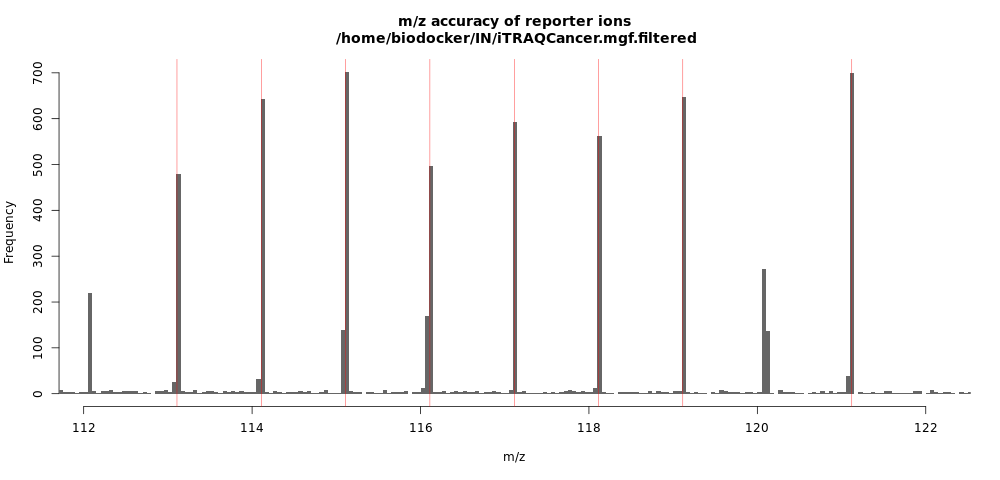

In [123]:
%%R --width=1000

print("Processing identification data...")


## assuming that the computer allows min. 4 threads
NumThreads <- 4

# library causes the execution to fail if the library is missing
suppressWarnings(suppressMessages(library(lattice)))
suppressWarnings(suppressMessages(library(stringr)))
suppressWarnings(suppressMessages(library(mzID)))
suppressWarnings(suppressMessages(library(MSnbase)))

# warnings as stdout
sink(stdout(), type = "message")

# change to the input directory
setwd(search_in["input_directory"][[1]])
out_dir <- search_in["workdir"][[1]]

## Folder names for different runs (e.g. different replicates, ...)
samples <- unique(ExpDesign$spec_dir)
sampledirs <- unlist(sub(search_in["input_directory"][[1]],"",samples))
names(sampledirs) <- samples
print(sampledirs)


PSMDat <- PepDat <- ProtDat <- list()
for (s in samples) {
    ## Organize technical runs in the same folder
    # filenames
    print(paste("Processing files from folder",s))
    
    ident_files <- unlist(search_out)
    mgf_files <- list.files(s,pattern="mgf.filtered$",full.names = T)
  
    # make sure all input files exist
    if (is.null(ident_files)) {
        stop("Error: No identification files")
    }
    if (is.null(mgf_files)) {
        stop("Error: No spectrum files")
    }
    if (!file.exists(ident_files)) {
        stop("Error: Cannot find identification files ", ident_files)
    }
    for (mgf_file in mgf_files) {
        if (!file.exists(mgf_file)) {
            stop("Error: Cannot find mgf file ", mgf_file)
        }
    }
    
    # ---- load the PSMs ----
    max.fdr <- search_in["target_fdr"]
    psms <- read.csv(ident_files, sep = "\t",stringsAsFactors = F)
  
    if (! "Decoy" %in% names(psms)) {
        stop("Error: No decoy information available in output file")
    }
  
    print(paste("Loaded",nrow(psms), "PSMs"))
  
    # ---- Confidence filter ----
    # TODO: This could be replaced by the PeptideShaker functionality
    psms <- psms[order(psms[, "Confidence...."], decreasing = T), ]
    decoy.psms <- which(psms[, "Decoy"] == "1")
  
    decoy.count <- 0
  
    for (decoy.index in decoy.psms) {
        decoy.count <- decoy.count + 1
        target.count <- decoy.index - decoy.count
        cur.fdr <- (decoy.count * 2) / (decoy.count + target.count)
    
        if (cur.fdr > max.fdr) {
          # filter
          psms <- psms[1:decoy.index - 1,]
          break
        }
    }
  
    print(paste0("Filtered ", nrow(psms), " PSMs @ ", max.fdr, " FDR"))
    
    if (nrow(psms) < 1) {
        stop("Error: No valid PSMs found")
    }
    
    # ---- prepare for MSnbase ----
    psms$rank <- 1
    psms$desc <- psms$Protein.s.
    psms$spectrumID <- psms$Spectrum.Title #str_extract(psms$Spectrum.Title, "scan=[0-9]*")
    psms$spectrumFile <- psms$Spectrum.File
    psms$idFile <- ident_files
    # remove unnecessary PTMs from modified sequence
    # TODO: define whether to take oxidation, ...
    psms$Modified.Sequence <- gsub("<cmm>","",psms$Modified.Sequence)
    psms$Modified.Sequence <- sub("[a-z,A-Z]*-","",psms$Modified.Sequence)
    psms$Modified.Sequence <- sub("-[a-z,A-Z]*","",psms$Modified.Sequence)
    psms$Modified.Sequence <- gsub("<iTRAQ>","",psms$Modified.Sequence)
    psms$Modified.Sequence <- gsub("<TMT>","",psms$Modified.Sequence)
    psms$sequence <- psms$Modified.Sequence
    # Optional:
    # psms$Modified.Sequence <- gsub("<ox>","",psms$Modified.Sequence)
  
    # --- Load the spectra ----
    allSpectra <- list()
    for (mgf_file in mgf_files) {
        myExp1 <- readMgfData(mgf_file, verbose=T)
    
        for (i in 1:ncol(fData(myExp1))) {
          if (is.factor(fData(myExp1)[,i]))
            fData(myExp1)[,i] <- as.character(fData(myExp1)[,i])
        }
        fData(myExp1)$spectrumFile <- mgf_file
        allSpectra[[mgf_file]] <- myExp1
    }
    
    # ---- merge identification and spectra data and run the quantification ----
    # get the MSnbase quantification object
    known.methods <- c("TMT10","TMT6","iTRAQ4","iTRAQ8","iTRAQ4", "iTRAQ8")
    selected.method <- gsub(" \\(.*", "", search_in["labelling_method"][[1]])
    
    if (!selected.method %in% known.methods) {
        stop("Error: Labelling method not supported")
    }
    
    quant.method <- get(selected.method)
    
    # run the merging and quantification in paralell
    cl <- makeCluster(NumThreads)
    myExp <- qnt <- list()
    for (mgf_file in mgf_files) {
        myExp[[mgf_file]] <- addIdentificationData(
            allSpectra[[mgf_file]],
            psms,
            decoy="Decoy",
            rank="rank",
            acc="Protein.s.",
            icol="Spectrum.Title",
            fcol="TITLE",
            desc="desc",
            pepseq="Modified.Sequence",
            verbose=T)
        # print(idSummary(myExp[[mgf_file]]))
        
        # remove all unidentified spectra
        myExp[[mgf_file]] <- removeNoId(myExp[[mgf_file]])
        
        # quantify everything
        qnt[[mgf_file]] <- quantify(myExp[[mgf_file]], 
                                    method = "sum", 
                                    reporters = quant.method, 
                                    strict = F, verbose = T )
      
        # Plot reporter QC
        hist(unlist(mz(myExp[[mgf_file]])), 1000, main=paste("m/z accuracy of reporter ions\n",mgf_file), 
            xlim=range(quant.method@mz)+c(-1,1),xlab="m/z",col="#666666",border=NA)
        abline(v=quant.method@mz,col=2,lwd=0.5)
    } 
    
    stopCluster(cl)
    
    # ---- run the impurity correction ----
    imp <- makeImpuritiesMatrix(length(quant.method),edit=F)
    for (i in 1:length(qnt)) {
        qnt[[i]] <- purityCorrect(qnt[[i]],imp)
        exprs(qnt[[i]]) <- log2(exprs(qnt[[i]]))
        qnt[[i]] <- normalise(qnt[[i]],"center.median")
        qnt[[i]] <- updateFeatureNames(qnt[[i]],label = paste("Sample",i))
    }
    
    # ---- combine the quantification data ----
    names(qnt) <- NULL
    allqnt <- do.call("combine",args=qnt)
    allqnt <- filterNA(allqnt, pNA=0.5)

    # ---- add the sample annotations ----
    
    if (nrow(ExpDesign) != nrow(pData(allqnt))) {
        stop("Error: Experimental design does not fit the number of quantified ions.")
    }

    # merge the annotations
    pdata.org <- pData(allqnt)
    pdata.combined <- merge(pdata.org, ExpDesign, all.x = T, all.y = F, by.x = 0, by.y = "channel")
    rownames(pdata.combined) <- pdata.combined[, "Row.names"]
    pdata.combined$Row.names <- NULL

    # save
    pData(allqnt) <- pdata.combined[colnames(allqnt), ]
  
    ## Setting the stage for the iPQF inference method
    names(fData(allqnt))[which(names(fData(allqnt))=="Protein.s.")] <- "accession"
    names(fData(allqnt))[which(names(fData(allqnt))=="Variable.Modifications")] <- "modifications"
    names(fData(allqnt))[which(names(fData(allqnt))=="m.z")] <- "mass_to_charge"
    names(fData(allqnt))[which(names(fData(allqnt))=="Confidence....")] <- "search_engine_score"
    
    
    write.csv(exprs(allqnt),paste(out_dir,"/",sampledirs[s],"/AllQuantPSMs.csv",sep=""))  
    save(allqnt, file=paste(out_dir,"/",sampledirs[s],"/AllQuantPSMs.RData",sep="") )
    
    PSMDat[[s]] <- allqnt 
}    
 

### Basic Quality Control

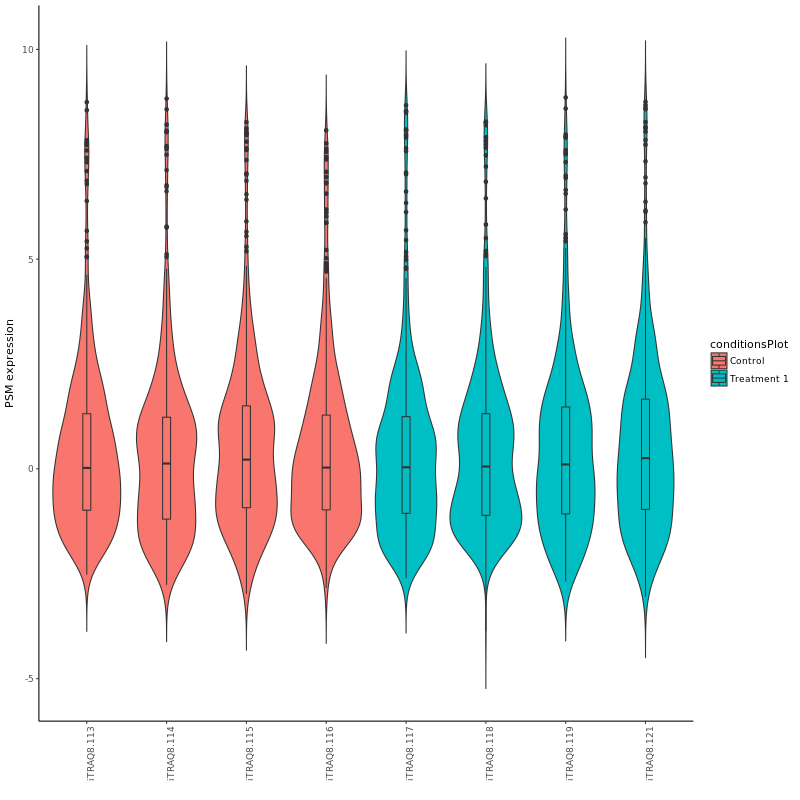

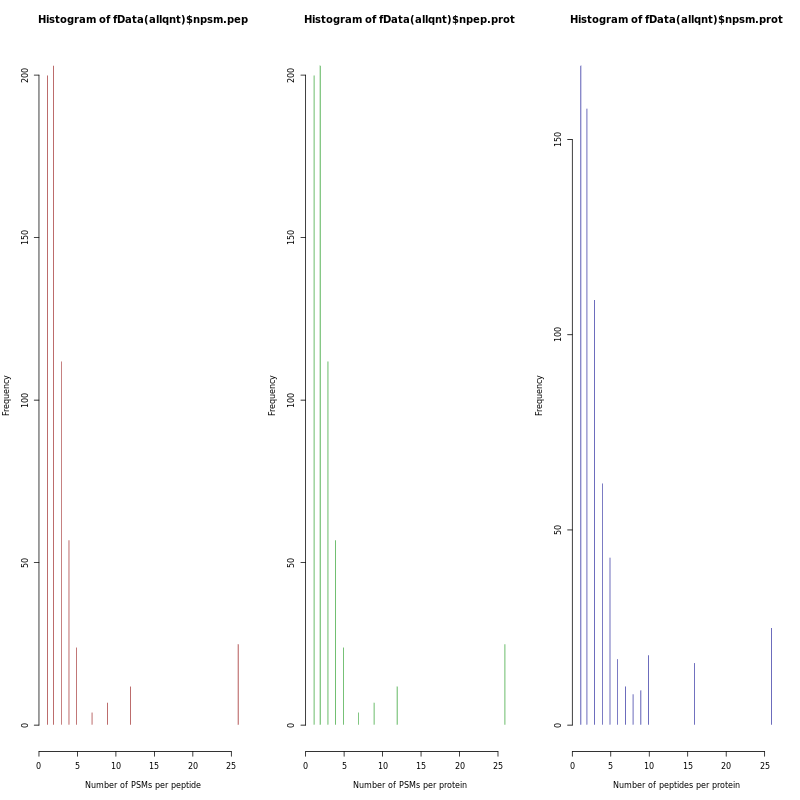

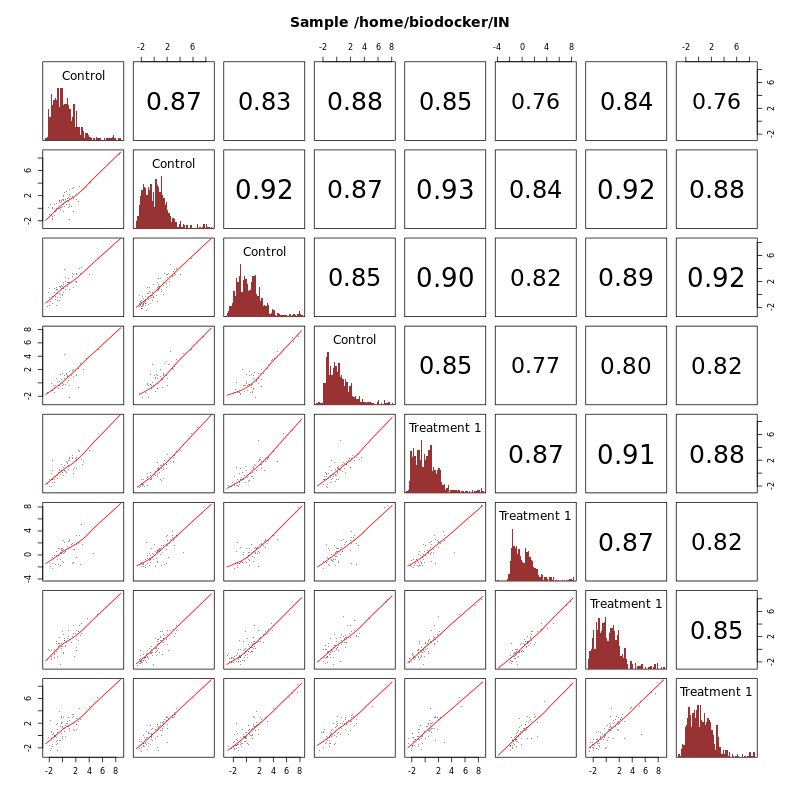

In [169]:
%%R --width 800 --height 800


suppressWarnings(suppressMessages(library(plotly)))
suppressWarnings(suppressMessages(library(reshape)))


panel.cor <- function(x, y, digits=2, prefix="", cex.cor, ...) 
{
    usr <- par("usr"); on.exit(par(usr)) 
    par(usr = c(0, 1, 0, 1)) 
    r <- abs(cor(x, y, use="na.or.complete")) 
    txt <- format(c(r, 0.123456789), digits=digits)[1] 
    txt <- paste(prefix, txt, sep="") 
    cex.cor <- 0.8/strwidth(txt) 
    test <- cor.test(x,y) 
    # borrowed from printCoefmat
    Signif <- symnum(test$p.value, corr = FALSE, na = FALSE, 
                  cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1),
                  symbols = c("***", "**", "*", ".", " ")) 
 
    text(0.5, 0.5, txt, cex = cex.cor * r) 
}

panel.hist <- function(x, hist.col="#993333", ...)
{
    usr <- par("usr"); on.exit(par(usr))
   par(usr = c(usr[1:2], 0, 1.5) )
    h <- hist(x, plot = FALSE, border=NA,breaks=50)
    breaks <- h$breaks; nB <- length(breaks)
  y <- h$counts; y <- y/max(y)
    rect(breaks[-nB], 0, breaks[-1], y,col=hist.col,border=NA)
}

for (s in samples) {
    allqnt <- PSMDat[[s]]
    
    condNames <- ExpDesign[ExpDesign$spec_dir == s,"sample_orig"]
    conditions <- condNames
    if (sampledirs[s] != "")
    condNames <- paste(condNames, sampledirs[s], sep="\n")
    pData(allqnt)$sample_name <- paste(condNames, sampledirs[s])
    pData(allqnt)$sample_group <- condNames
    
    
    ## QC Plots
  #boxplot(exprs(allqnt), main =paste("Sample",s), labels =  condNames)
    
    
       conditionsPlot <- rep(conditions, each=nrow(exprs(allqnt)))
    p <- ggplot(melt(exprs(allqnt)), aes(x=X2, y=value, fill=conditionsPlot)) + geom_violin(trim=FALSE) + 
    geom_boxplot(width=0.1) + theme_classic() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    xlab("") + ylab("PSM expression")
    print(p)
        par(mfrow=c(1,3))
    hist(fData(allqnt)$npsm.pep,xlab="Number of PSMs per peptide",100,border=0,col="#AA4444")
    hist(fData(allqnt)$npep.prot,xlab="Number of PSMs per protein",100,border=0,col="#44AA44")
    hist(fData(allqnt)$npsm.prot,xlab="Number of peptides per protein",100,border=0,col="#4444AA")

    par(mfrow=c(1,1))
    
    
  pairs(exprs(allqnt),lower.panel=panel.smooth, upper.panel=panel.cor, diag.panel=panel.hist, main = paste("Sample",s),
cex=0.1,col="#33333388",pch=15, labels =  condNames)
    
    PSMDat[[s]] <- allqnt
    
    
  #print(fData(allqnt))  
}

    


### Protein Inference

[1] "Files from /home/biodocker/IN"
[1] "Using  iPQF for summarization to proteins ..."
[1] "Removing 252 PSMs with missing values for quantification"
[1] "Removing 0 PSMs corresponding to 0 proteins with less then 1 peptides"


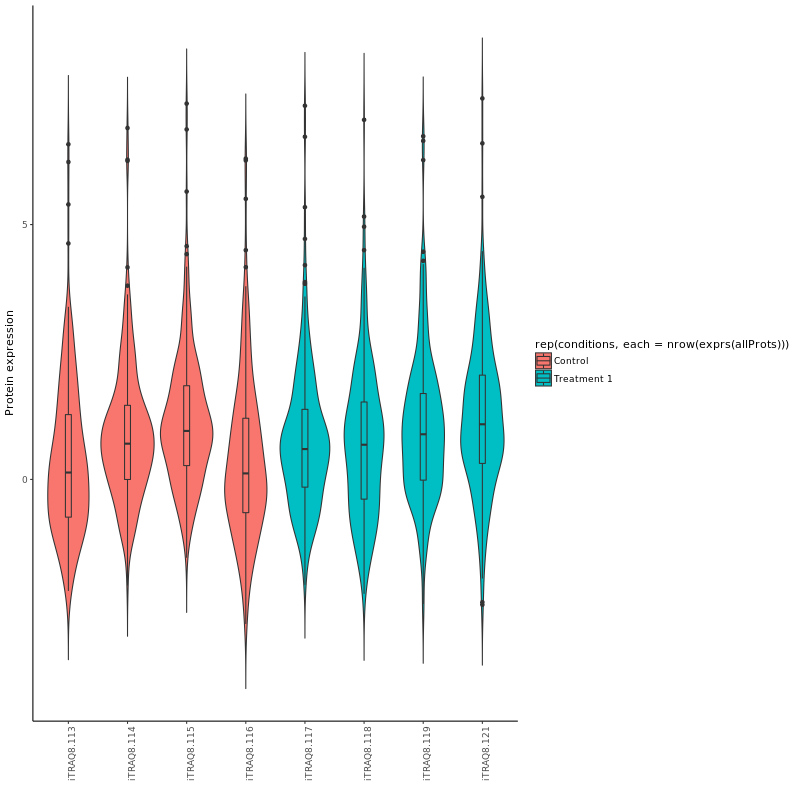

In [167]:
%%R --width 800 --height 800

####### TODO: implement considering PTMs (or not)

for (s in samples) {
    load(paste(out_dir,"/",sampledirs[s],"/AllQuantPSMs.RData",sep=""))

    print(paste("Files from",s))
    
    allqnt <- PSMDat[[s]]
    
    #print(colnames(fData(allqnt)))
    
    # get the selected method
    summarization.function <- search_in["summarization_method"][[1]]
    
    # get minimum peptides
    min_peps <- search_in["min_protein_psms"][[1]]
    
    
    print(paste("Using ",summarization.function,"for summarization to proteins ..."))

    # keep only PSMs with at least 50% coverage over samples
    
    allProts <- NULL
    # remove missing values for iPQF
    if(summarization.function == "iPQF") {
        exprs(allqnt) <- 2^exprs(allqnt)
        # remove all spectra with missing values
        has.missing.values <- (rowSums(is.na(exprs(allqnt))) > 0 | rowSums(exprs(allqnt) == 0)) > 0    
        print(paste0("Removing ", sum(has.missing.values), " PSMs with missing values for quantification"))
        allqnt <- filterNA(allqnt,0.0)
           
        # filter for minimal peptide number
    has_too_few_peps <- fData(allqnt)$npep.prot < min_peps
    num_prot_rm <- length(unique(fData(allqnt)[has_too_few_peps, "accession"]))
    print(paste("Removing",sum(has_too_few_peps),"PSMs corresponding to",num_prot_rm,"proteins with less then",min_peps,"peptides"))

        allProts <- combineFeatures(allqnt, 
                                groupBy=fData(allqnt)$accession, 
                                verbose=F)
        exprs(allProts) <- log2(exprs(allProts))
    } else {
    
        # remove all spectra with missing values
        has.missing.values <- rowSums(is.na(exprs(allqnt)) | rowSums(exprs(allqnt) == 0, na.rm=T)) > NumCond*0.5    
        print(paste0("Removing ", sum(has.missing.values), " PSMs with more than 50% missing values for quantification"))
        allqnt <- allqnt[!has.missing.values, ]

                # filter for minimal peptide number
    has_too_few_peps <- fData(allqnt)$npep.prot < min_peps
    num_prot_rm <- length(unique(fData(allqnt)[has_too_few_peps, "accession"]))
    print(paste("Removing",sum(has_too_few_peps),"PSMs corresponding to",num_prot_rm,"proteins with less then",min_peps,"peptides"))

        allProts <- combineFeatures(allqnt, na.rm=T,
                                groupBy=fData(allqnt)$accession, 
                                verbose=F)
    }
 
    # create a plot of all protein expression values
    p <- ggplot(melt(exprs(allProts)), aes(x=X2, y=value, fill=rep(conditions,each=nrow(exprs(allProts))))) + 
            geom_violin(trim=FALSE) + 
            geom_boxplot(width=0.1) +
            theme_classic() + 
            theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
            xlab("") + 
            ylab("Protein expression")

    # display the plot
    print(p)

    # save the expression values
    write.exprs(allProts,file=paste(out_dir,"/",sampledirs[s],"/AllQuantProteins.csv",sep=""))
  
    ProtDat[[s]] <- allProts <- exprs(allProts)
    colnames(ProtDat[[s]]) <- condNames
}

## Further Analysis

[1] "Merging samples (if needed) ..."
[1] "Quantified a total of 221 protein groups"
[1] "Statistical tests carried out to compare: Treatment.1-Control"


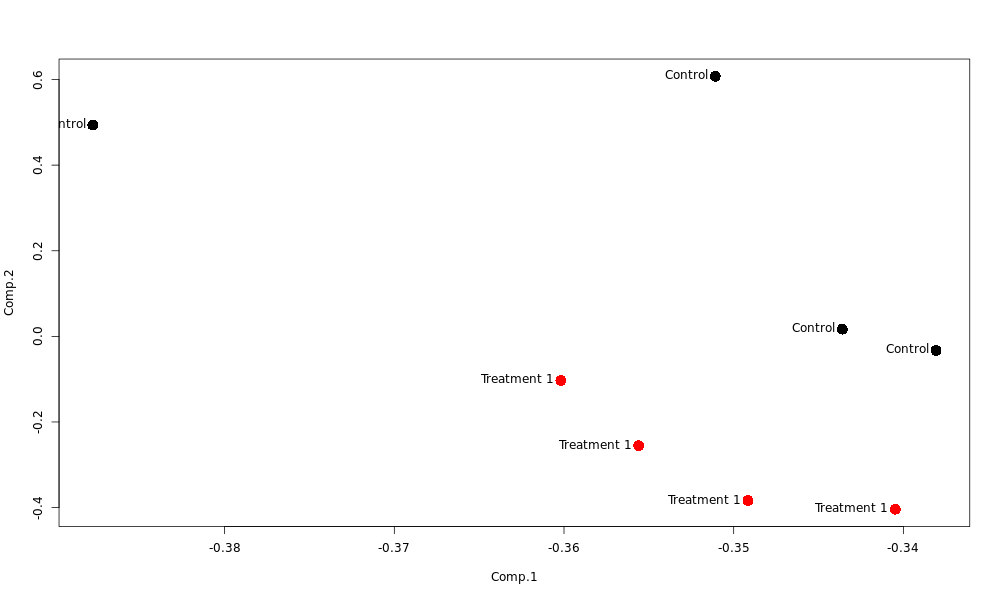

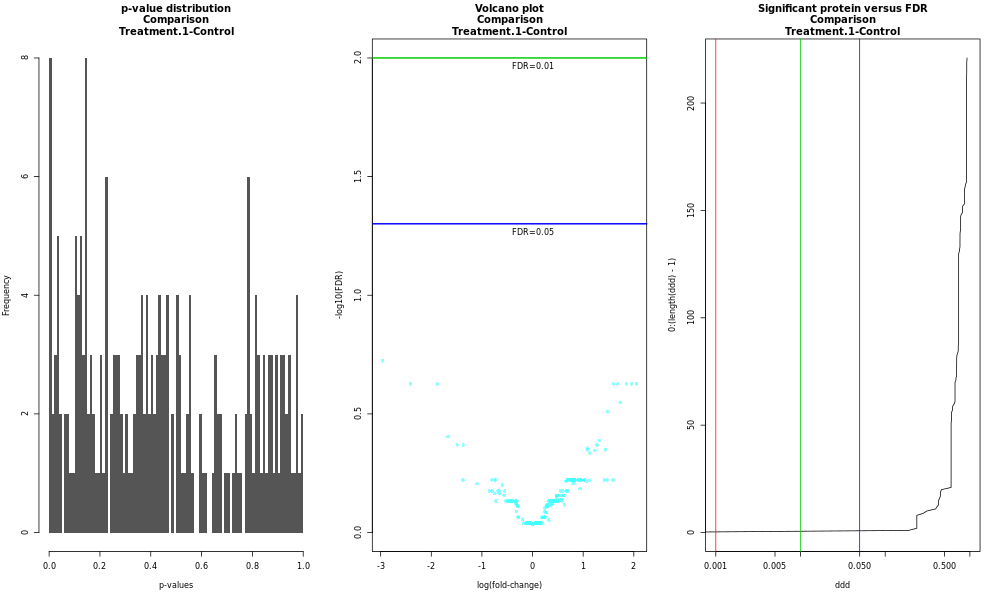

In [168]:
%%R --width 1000 --height 600

print("Merging samples (if needed) ...")

par(mfrow=c(1,1))


# Merge different samples
    totProts <- ProtDat[[1]]
if (length(samples)>1) {
    for (s in samples[2:length(samples)])
    totProts <- merge(totProts,ProtDat[[s]], all=T, by.x=1, by.y=0)
} 

write.csv(totProts,file=paste(out_dir,"/AllQuantProteinsInAllSamples.csv",sep=""))

# PCA
  pca <- princomp(totProts[complete.cases((totProts)),])
  #plot(pca)
  plot(pca$loadings, cex=2, pch=16, col=as.numeric(as.factor(ExpDesign[["sample_orig"]])))
  text(pca$loadings,colnames(totProts), pos=2)
    
  print(paste("Quantified a total of",nrow(allProts),"protein groups"))



##Statistics
library(limma)
library(qvalue)
NumCond <- length(unique(ExpDesign$sample_orig))
  if (NumCond < 2)
      stop("Only 1 experimental condition -> no statistics")

design <- model.matrix(~0+factor(ExpDesign$sample_group)-1)
  colnames(design)<-make.names(paste(unique(ExpDesign$sample_orig),sep=""))
  contrasts<-NULL
  First <- 1
  for (i in (1:NumCond)[-First]) contrasts<-append(contrasts,paste(colnames(design)[i],"-",colnames(design)[First],sep=""))
  print(paste("Statistical tests carried out to compare:",contrasts))
  contrast.matrix<-makeContrasts(contrasts=contrasts,levels=design)
  # print(dim(Data))
  lm.fitted <- lmFit(totProts,design)
  lm.contr <- contrasts.fit(lm.fitted,contrast.matrix)
  lm.bayes <- eBayes(lm.contr)
  #topTable(lm.bayes)
 plvalues <- lm.bayes$p.value
fcs <- lm.bayes$coefficients
  qlvalues <- matrix(NA,nrow=nrow(plvalues),ncol=ncol(plvalues),dimnames=dimnames(plvalues))
  # qvalue correction
 for (i in 1:ncol(plvalues)) {
    tqs <- qvalue(na.omit(plvalues[,i]))$qvalues
    qlvalues[names(tqs),i] <- tqs
  }
  

par(mfrow=c(1,3))

statTable <- NULL

# Visualizations: volcano plot, number of regulated proteins per FDR, interactive table?
for (i in 1:ncol(plvalues)) {
    hist(plvalues[,i],100,border=NA,col="#555555", main=paste("p-value distribution\nComparison",colnames(fcs)[i], sep="\n"),
        xlab="p-values")
    plot(fcs[,i], -log10(qlvalues[,i]),pch=16,col="#44FFFF99",
        xlab="log(fold-change)", ylab="-log10(FDR)", main=paste("Volcano plot\nComparison",
                                                                colnames(fcs)[i], sep="\n"),
        ylim=c(0,max(2,max(-log10(qlvalues[,i])))))
    abline(h=-log10(c(0.001,0.01,0.05)), col=2:4,lwd=2)
    text(c(0,0,0), c(3,2,1.3),c("FDR=0.001","FDR=0.01","FDR=0.05"),pos=1)
    ddd <- c(0.0001,sort(qlvalues[,i]))
plot(ddd, 0:(length(ddd)-1),type="l",xlim=c(1e-3,1),log="x", main=paste("Significant protein versus FDR\nComparison",colnames(fcs)[i], sep="\n")) 
    abline(v=c(0.001,0.01,0.05), col=2:4, xlab="FDR", ylab="Number of proteins")
    
}

# How far should we go? Clustering (when having more then 2 groups)? 
# Hierarchical clustering of significant features? clusterProfiler?


# Saving stats
statOut <- cbind(fcs, plvalues, qlvalues)
colnames(statOut) <- paste(rep(c("log(fold-change)","p-values","q-values"), each=ncol(plvalues)), colnames(statOut))
statOut <- cbind(Proteins=rownames(fcs),statOut)
#print(head(statOut))
write.csv(statOut, "/home/biodocker/OUT/DifferentiallyRegulatedProteins.csv",row.names=F)




In [147]:
%%R

# test ground for interactive apps
library(plotly)
library(reshape)

#print(head(melt(allProts)))

x <- rnorm(1000)
y <- rchisq(1000, df = 1, ncp = 0)
group <- sample(LETTERS[1:5], size = 1000, replace = T)
size <- sample(1:5, size = 1000, replace = T)

ds <- data.frame(x, y, group, size)

p <- plot_ly(ds, x = x, y = y, mode = "markers", split = group, size = size) %>%
  layout(title = "Scatter Plot")
embed_notebook(p)
print(p)

No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Error in htmlwidgets::saveWidget(p, tmp) : 
  Saving a widget with selfcontained = TRUE requires pandoc. For details see:
https://github.com/rstudio/rmarkdown/blob/master/PANDOC.md
In addition: Warning messages:
1: Removed 217 rows containing non-finite values (stat_ydensity). 
2: Removed 217 rows containing non-finite values (stat_boxplot).
Error in htmlwidgets::saveWidget(p, tmp) : 
  Saving a widget with selfcontained = TRUE requires pandoc. For details see:
https://github.com/rstudio/rmarkdown/blob/master/PANDOC.md


In [ ]:
%%R

ddd <- sort(qlvalues[,1])
plot(ddd, 1:length(ddd),type="l")